In [21]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import zipfile

# Mount Google Drive (if your data is there)
from google.colab import drive
drive.mount('/content/drive')

# If you've uploaded archive.zip directly to Colab:
!unzip /content/archive.zip

Mounted at /content/drive
Archive:  /content/archive.zip
  inflating: ball.csv                
  inflating: bat.csv                 
  inflating: match.csv               


In [22]:
# Load the datasets
bowling_df = pd.read_csv('ball.csv')
batting_df = pd.read_csv('bat.csv')
matches_df = pd.read_csv('match.csv')

# Basic info
print("Bowling Data Shape:", bowling_df.shape)
print("Batting Data Shape:", batting_df.shape)
print("Matches Data Shape:", matches_df.shape)

# Display first few rows
print("\nBowling Data Sample:")
display(bowling_df.head())

print("\nBatting Data Sample:")
display(batting_df.head())

print("\nMatches Data Sample:")
display(matches_df.head())

Bowling Data Shape: (36149, 30)
Batting Data Shape: (52492, 28)
Matches Data Shape: (6199, 15)

Bowling Data Sample:


,Unnamed: 0,name_x,playing_role,id,order,run_conceded,maidens,wickets,overs,economy,...,matchtype,series_id,match_detail_id,title,runs,over,run_rate,match_id,opp_team_id,team_id
0,8526,Ajit Agarkar,BOWL,8544,2,51,0,2,10.0,5.10,...,odi,182,773,Bangladesh Innings,234,50.0,4.68,633,2,7
1,8518,Tapash Baisya,NaN,8536,0,67,0,2,10.0,6.70,...,odi,182,773,India Innings,245,50.0,4.90,633,7,2
2,8519,Mushfiqur Rahman,NaN,8537,1,29,0,1,6.0,4.83,...,odi,182,773,India Innings,245,50.0,4.90,633,7,2
3,8520,Nazmul Hossain,BOWL,8538,2,39,1,2,9.0,4.33,...,odi,182,773,India Innings,245,50.0,4.90,633,7,2
4,8521,Khaled Mahmud,NaN,8539,3,43,0,1,10.0,4.30,...,odi,182,773,India Innings,245,50.0,4.90,633,7,2



Batting Data Sample:


,Unnamed: 0,name_x,playing_role,id,order,runs_x,balls,strike_rate,fours,sixes,...,matchtype,series_id,match_detail_id,title,runs_y,over,run_rate,match_id,opp_team_id,team_id
0,13463,Tapash Baisya,NaN,13464,9,7,5,140.00,1,0,...,odi,182,773,Bangladesh Innings,234,50.0,4.68,633,2,7
1,13462,Khaled Mahmud,NaN,13463,8,21,17,123.52,3,0,...,odi,182,773,Bangladesh Innings,234,50.0,4.68,633,2,7
2,13459,Rajin Saleh,NaN,13460,5,14,28,50.00,1,0,...,odi,182,773,Bangladesh Innings,234,50.0,4.68,633,2,7
3,13461,Mushfiqur Rahman,NaN,13462,7,2,6,33.33,0,0,...,odi,182,773,Bangladesh Innings,234,50.0,4.68,633,2,7
4,13458,Aftab Ahmed,NaN,13459,4,30,49,61.22,2,1,...,odi,182,773,Bangladesh Innings,234,50.0,4.68,633,2,7



Matches Data Sample:


,Unnamed: 0,match_number,name,start_date,matchtype,series_id,match_detail_id,scorecard_id,title,runs,over,run_rate,match_id,opp_team_id,team_id
0,1417,1.0,Bangladesh v India,2004-12-22 18:30:00+00:00,odi,182,773,1495,India Innings,245,50.0,4.90,633,7,2
1,1418,1.0,Bangladesh v India,2004-12-22 18:30:00+00:00,odi,182,773,1496,Bangladesh Innings,234,50.0,4.68,633,2,7
2,1419,2.0,Bangladesh v India,2004-12-25 18:30:00+00:00,odi,182,774,1497,Bangladesh Innings,229,50.0,4.58,634,2,7
3,1420,2.0,Bangladesh v India,2004-12-25 18:30:00+00:00,odi,182,774,1498,India Innings,214,47.5,4.47,634,7,2
4,1421,3.0,Bangladesh v India,2004-12-26 18:30:00+00:00,odi,182,775,1499,India Innings,348,50.0,6.96,635,7,2


In [24]:
# Handle missing values
bowling_df.fillna(0, inplace=True)
batting_df.fillna(0, inplace=True)

# Merge datasets to create comprehensive player performance data
# For bowling data
bowling_performance = bowling_df.merge(matches_df, on='match_id', how='left')

# For batting data
batting_performance = batting_df.merge(matches_df, on='match_id', how='left')

# Calculate fantasy points (example calculation - adjust based on your platform's rules)
def calculate_bowling_points(row):
    points = row['wickets'] * 25  # 25 points per wicket
    if row['wickets'] >= 3:
        points += 25  # 25 bonus for 3+ wickets
    if row['wickets'] >= 5:
        points += 50  # 50 bonus for 5+ wickets
    points += row['maidens'] * 12  # 12 points per maiden over
    points -= row['run_conceded'] * 0.5  # -0.5 per run conceded
    return points

def calculate_batting_points(row):
    points = row['runs'] * 1  # 1 point per run
    if row['runs'] >= 30:
        points += 25  # 25 bonus for 30+ runs
    if row['runs'] >= 50:
        points += 50  # 50 bonus for 50+ runs
    if row['runs'] >= 100:
        points += 100  # 100 bonus for century
    points += row['fours'] * 1  # 1 point per four
    points += row['sixes'] * 2  # 2 points per six
    points += row['strike_rate'] * 0.1  # 0.1 per strike rate unit (adjust based on range)
    return points

# Apply point calculations
bowling_performance['fantasy_points'] = bowling_performance.apply(calculate_bowling_points, axis=1)
batting_performance['fantasy_points'] = batting_performance.apply(calculate_batting_points, axis=1)

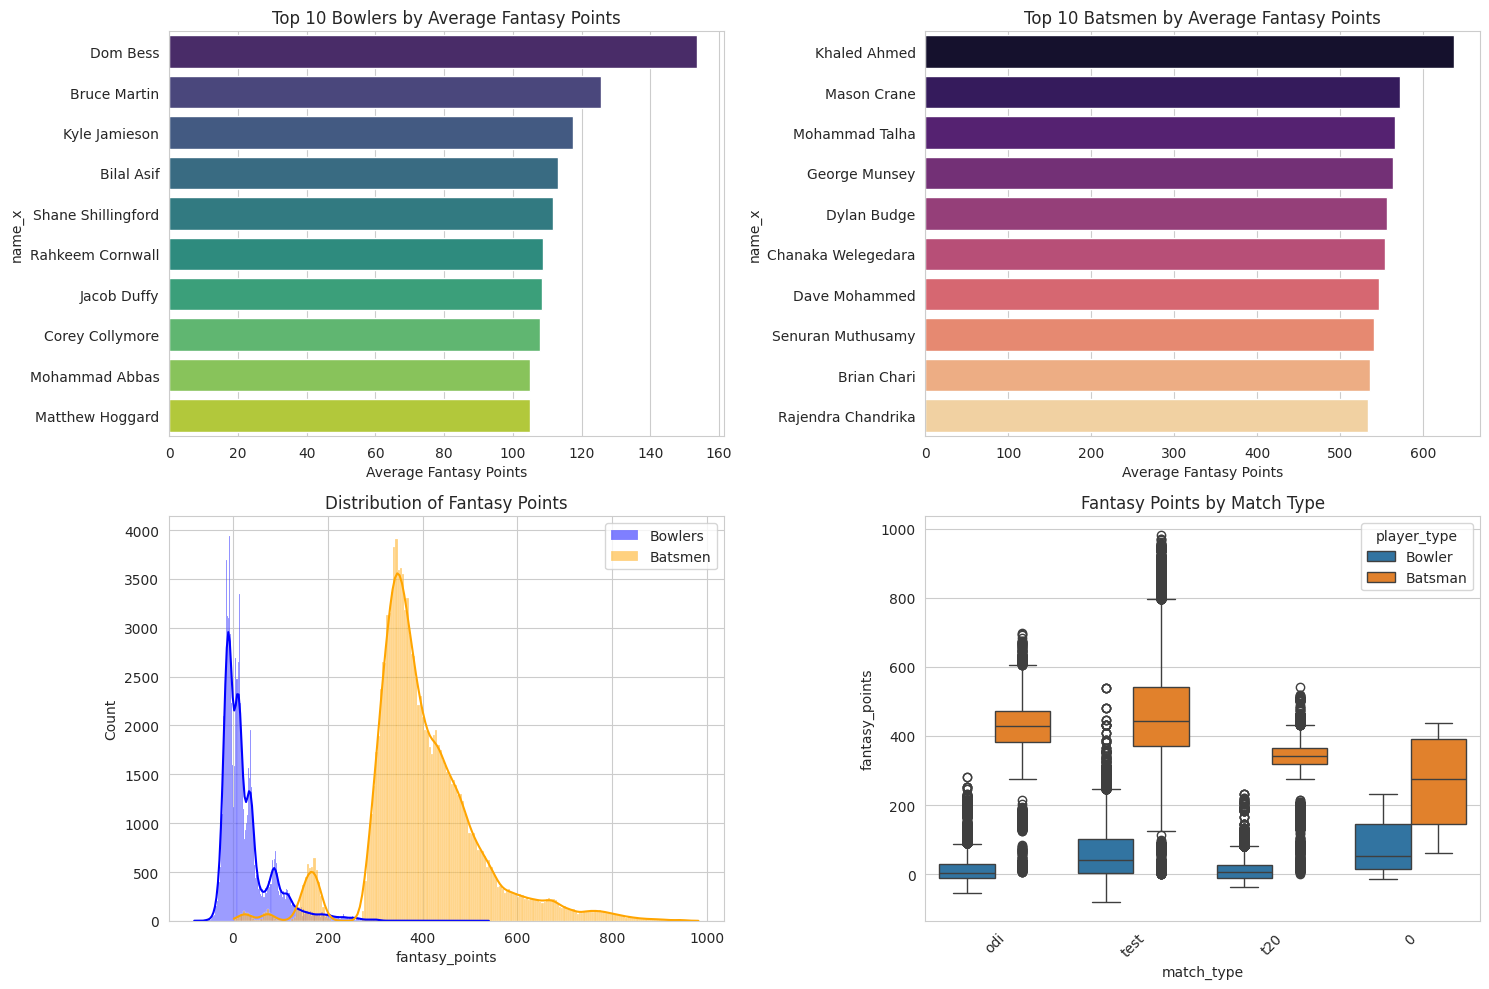

In [28]:
# Set style
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

# First create a combined DataFrame with correct column names
combined_df = pd.concat([
    bowling_performance.rename(columns={'name_x': 'player', 'matchtype_x': 'match_type'})[['player', 'fantasy_points', 'match_type']].assign(player_type='Bowler'),
    batting_performance.rename(columns={'name_x': 'player', 'matchtype_x': 'match_type'})[['player', 'fantasy_points', 'match_type']].assign(player_type='Batsman')
])

# Top 10 bowlers by average fantasy points
top_bowlers = bowling_performance.groupby('name_x')['fantasy_points'].mean().sort_values(ascending=False).head(10)
plt.subplot(2, 2, 1)
sns.barplot(x=top_bowlers.values, y=top_bowlers.index, palette='viridis')
plt.title('Top 10 Bowlers by Average Fantasy Points')
plt.xlabel('Average Fantasy Points')

# Top 10 batsmen by average fantasy points
top_batsmen = batting_performance.groupby('name_x')['fantasy_points'].mean().sort_values(ascending=False).head(10)
plt.subplot(2, 2, 2)
sns.barplot(x=top_batsmen.values, y=top_batsmen.index, palette='magma')
plt.title('Top 10 Batsmen by Average Fantasy Points')
plt.xlabel('Average Fantasy Points')

# Distribution of fantasy points
plt.subplot(2, 2, 3)
sns.histplot(bowling_performance['fantasy_points'], color='blue', label='Bowlers', kde=True)
sns.histplot(batting_performance['fantasy_points'], color='orange', label='Batsmen', kde=True)
plt.title('Distribution of Fantasy Points')
plt.legend()

# Fantasy points by match type
plt.subplot(2, 2, 4)
sns.boxplot(x='match_type', y='fantasy_points', hue='player_type', data=combined_df)
plt.title('Fantasy Points by Match Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Bowling Performance Columns: ['Unnamed: 0_x', 'name_x', 'playing_role', 'id', 'order', 'run_conceded', 'maidens', 'wickets', 'overs', 'economy', 'wides', 'no_balls', 'fours', 'sixes', 'zeros', 'player_id', 'scorecard_id_x', 'match_number_x', 'name_y', 'start_date_x', 'matchtype_x', 'series_id_x', 'match_detail_id_x', 'title_x', 'runs_x', 'over_x', 'run_rate_x', 'match_id', 'opp_team_id_x', 'team_id_x', 'Unnamed: 0_y', 'match_number_y', 'name', 'start_date_y', 'matchtype_y', 'series_id_y', 'match_detail_id_y', 'scorecard_id_y', 'title_y', 'runs_y', 'over_y', 'run_rate_y', 'opp_team_id_y', 'team_id_y', 'fantasy_points']
Random Forest RMSE: 0.33
XGBoost RMSE: 0.81


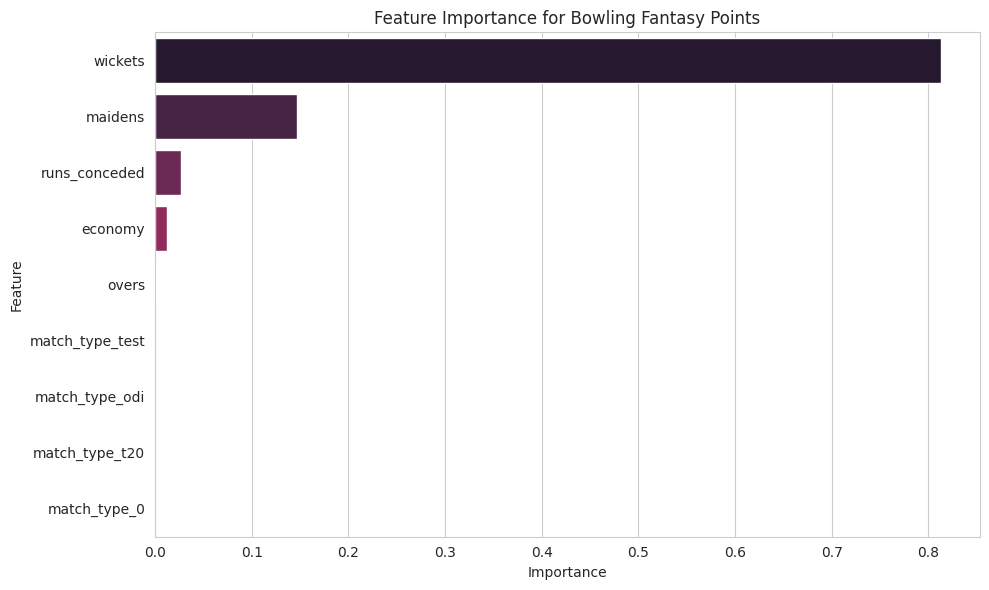

In [30]:
# First, let's verify the correct column names
print("Bowling Performance Columns:", bowling_performance.columns.tolist())

# Prepare bowling data for modeling with correct column names
bowling_features = bowling_performance[['overs', 'maidens', 'run_conceded', 'wickets', 'economy', 'matchtype_x']]
bowling_features = bowling_features.rename(columns={
    'run_conceded': 'runs_conceded',
    'matchtype_x': 'match_type'
})

# One-hot encode categorical variables
bowling_features = pd.get_dummies(bowling_features, columns=['match_type'])

bowling_target = bowling_performance['fantasy_points']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    bowling_features, bowling_target, test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
rf_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"Random Forest RMSE: {rf_rmse:.2f}")

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': bowling_features.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='rocket')
plt.title('Feature Importance for Bowling Fantasy Points')
plt.tight_layout()
plt.show()

In [33]:
def select_optimal_team(match_type='T20', budget=100):
    # Get recent performances (last 10 matches)
    recent_bowling = bowling_performance[bowling_performance['matchtype_x'] == match_type.lower()].groupby('name_x').tail(10)
    recent_batting = batting_performance[batting_performance['matchtype_x'] == match_type.lower()].groupby('name_x').tail(10)

    # Calculate average points
    bowler_avg = recent_bowling.groupby('name_x')['fantasy_points'].mean().reset_index()
    batsman_avg = recent_batting.groupby('name_x')['fantasy_points'].mean().reset_index()

    # Assign player values (simplified - in reality would have actual player values)
    bowler_avg['value'] = np.random.randint(8, 15, size=len(bowler_avg))
    batsman_avg['value'] = np.random.randint(8, 15, size=len(batsman_avg))

    # Optimization (knapsack problem approach)
    from itertools import combinations

    # We need 5-6 batsmen, 4-5 bowlers, 1-2 all-rounders (simplified selection)
    top_batsmen = batsman_avg.nlargest(15, 'fantasy_points')
    top_bowlers = bowler_avg.nlargest(15, 'fantasy_points')

    best_team = None
    best_score = 0

    # Simplified optimization - in reality would use more sophisticated approach
    for batsmen_count in range(5, 7):
        for bowlers_count in range(4, 6):
            for batsmen_combo in combinations(top_batsmen.iterrows(), batsmen_count):
                for bowlers_combo in combinations(top_bowlers.iterrows(), bowlers_count):
                    total_cost = sum([b[1]['value'] for b in batsmen_combo]) + sum([b[1]['value'] for b in bowlers_combo])
                    total_points = sum([b[1]['fantasy_points'] for b in batsmen_combo]) + sum([b[1]['fantasy_points'] for b in bowlers_combo])

                    if total_cost <= budget and total_points > best_score:
                        best_score = total_points
                        best_team = {
                            'batsmen': [b[1]['name_x'] for b in batsmen_combo],
                            'bowlers': [b[1]['name_x'] for b in bowlers_combo],
                            'total_cost': total_cost,
                            'expected_points': total_points
                        }

    if best_team is None:
        raise ValueError("No valid team found within the budget constraints")

    return best_team

# First check available match types
print("Available match types:", bowling_performance['matchtype_x'].unique())

# Get optimal team (use one of the available match types)
try:
    optimal_team = select_optimal_team('odi')  # Change to 't20' or other available type
    print("\nOptimal Fantasy Team:")
    print(f"Batsmen: {', '.join(optimal_team['batsmen'])}")
    print(f"Bowlers: {', '.join(optimal_team['bowlers'])}")
    print(f"Total Cost: {optimal_team['total_cost']}")
    print(f"Expected Points: {optimal_team['expected_points']:.1f}")
except ValueError as e:
    print(f"Error: {e}")

Available match types: ['odi' 'test' 't20' 0]

Optimal Fantasy Team:
Batsmen: George Munsey, Dylan Budge, Hasan Ali, Brendon McCullum, Ashley Nurse, Mushfiqur Rahim
Bowlers: Dave Mohammed, Lungi Ngidi, Al-Amin Hossain, Mark Watt
Total Cost: 100
Expected Points: 3500.1
